# Project 2
## Extending the Forest Fire model.

Author: Shayan Heidari

### Desciption:
Restoration and preservation of a wild fire

In [1]:
%matplotlib inline

import time, random, timeit
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

In [2]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)


def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

## Reused animation class

In [3]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

## New ForestFire class
This new class includes a water and lake simulation to make the model have more other external/natural factors

The water parameter includes the dimension(cube) of the water patches that appear throughout the forest. They represent firemen attempting to put out the forest fire. 
#### Water parameter
Such water patches do not get ignited again and are not fire "conductive". Meaning that they ultimately stop fires from occuring and spreading across them
#### Lake parameter
Only an initial setting that simulates initial random patches of natural lake across the forest. Showing how a forest can mitigate fires within itself without any external help.

#### Gathering metadata
An initial metadata array is created for the waters, making them last around 25 timesteps. They will spawn at a tunable property of 0.5

The water turns into forest right after 25 steps. Completely combusting again eventually. Water can't keep the forest from burning forever.

The water only appears on the forested parts and turns into forest again after those certain number of default steps.

### NEW ADDITION:
w: How biga cube of water is, in relative units

lakes: Only add lakes in the begining that are 'w' long in m

wc: Chances of water appearing on the map: responsiveness of fire units.

wl: Maximum [timesteps] life of a water cell when it randomly appears on the map


In [4]:
class ForestFire:
    """ 2D Cellular Automaton that simulates a fire-dominated landscape """

    # Define names for the 3 possible cell states
    EMPTY = 0
    OCCUPIED = 1
    WATER = 2
    DUD = 3
    FIRE = 5

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 1), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[FIRE] = (1, 0, 0)  # red
    
    
    
    
    cmap[WATER] = (0, 0, 1) # blue for water
    cmap[DUD] = (1,1,0)

    
    
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    #TODO: define a sensible correlation kernel
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])

    
    def __init__(self, n, p=0.01, f=0.001, q=0.5, w=3, lakes=0, wc=0.5, wl=25):
        """Initializes the model.

        n: number of rows
        p: probability an empty cells becomes "forested" (occupied)
        f: probability of spontaneous file (e.g., 1/fire ignition interval)
        q: initial forest density (probability cell is "forested" in initial state)
        
        NEW ADDITION:
        w: how long a strip of water is.
        lakes: only add lakes in the begining that are 'w' long in m
        wc: Chances of water appearing on the map: responsiveness of fire units.
        wl: Maximum [timesteps] life of a water cell when it randomly appears on the map
        
        """
        self.n = n
        self.wl = wl
        self.p = p
        self.f = f
        self.w = w
        self.wc = wc
        self.lakes = lakes
        # initialize landscape with approx. q proportion of cells OCCUPIED
        self.state = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1-q])
        
        gridSize = int(self.state.shape[0])
        if self.lakes != 0:
            for i in range(lakes):
                xCor = np.random.randint(gridSize)
                yCor = np.random.randint(gridSize)
                # The strip of water being put on by helicopters
                xCor1 = xCor + self.w
                yCor1 = yCor + self.w
                self.state[xCor:xCor1, yCor:yCor1] = self.WATER
        
        self.metadata = np.zeros_like(self.state)


    def step(self):
        """Executes one time step, applying the CA rules to regenerate and burn forest."""
        # TODO: define the rules for the CA.  This is a significant challenge b/c there are 4 rules and they must act independently!
        # Tips: develop 1 rule at a time, in the order above, leaving fire spread (correlation) till last.
        #       Compute each rule in 2 steps: (1) identify which cells the rule applies to; (2) update those cells.
        #       Use the next code block, below, to test as you go.
        
        # Apply the kernel
        activeForest = correlate2d(self.state, self.kernel, mode='same')
        
        occupied = self.state == self.OCCUPIED
        burning = self.state == self.FIRE
        empty = self.state == self.EMPTY
        
        
        water = self.state == self.WATER
        
        
        
                
                
        # Only a burning neighbor if it's on fire and not water
        neighbor = (activeForest >= self.FIRE) & (self.state == self.OCCUPIED) & (self.state != water)
        # reforestation
        self.state[empty] = np.random.choice([self.OCCUPIED, self.EMPTY], self.state[empty].shape, p=[self.p, 1-self.p])
        
        
        
    
        
        

    
    
        
        
        
        # ignite or forest
        self.state[occupied] = np.random.choice([self.OCCUPIED, self.FIRE], self.state[occupied].shape, p=[1-self.f, self.f]) #A cell with a tree spontaneously burns, with probability f, even if none of its neighbors is on fire
        
        self.state[occupied & neighbor] = self.FIRE
        
        self.state[burning] = self.EMPTY

        
  
        # Only if we want random waters. disappearing after 25 timesteps
        if self.lakes == 0 and (random.random() > self.wc):
            # Find tree chunks
            self.trees = np.argwhere(self.state == self.OCCUPIED)
            treesFound = len(self.trees)
            xCor, yCor = self.trees[ np.random.randint( treesFound ) ]
            # The strip of water being put on by helicopters
            xCor1 = xCor + self.w
            yCor1 = yCor + self.w
            self.state[xCor:xCor1, yCor:yCor1] = self.WATER
            
            self.metadata[xCor:xCor1, yCor:yCor1] += 1
            
            indices = np.argwhere(self.metadata > 0)
            for idx in indices:
                self.metadata[idx[0], idx[1]] += 1
                
                if self.metadata[idx[0], idx[1]] > self.wl:
                    self.state[idx[0], idx[1]] = self.OCCUPIED
                    # reset age
                    self.metadata[idx[0], idx[1]] = 0
                    
                    
                
      
    def num_occupied(self, arg=OCCUPIED):
        """ return the number of cells occupied by forest """
        occupiedCellsBool = self.state == arg
        # occupiedCellsBool = self.state[self.state == self.OCCUPIED]
        return np.sum(self.state[occupiedCellsBool])


    def pct_occupied(self, arg=OCCUPIED):
        """ return the proportion of cells occupied by forest """
        return self.num_occupied(arg) / self.state.size

    def draw(self, axes=None, step='', arg=OCCUPIED):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.axes
        title = f'Time:{step} Occupied: {round(self.pct_occupied(arg) * 100, 2)}%'
        #title = "bruh"
        plot_2D_array(self.state, axes=axes, title=title,
                      cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))

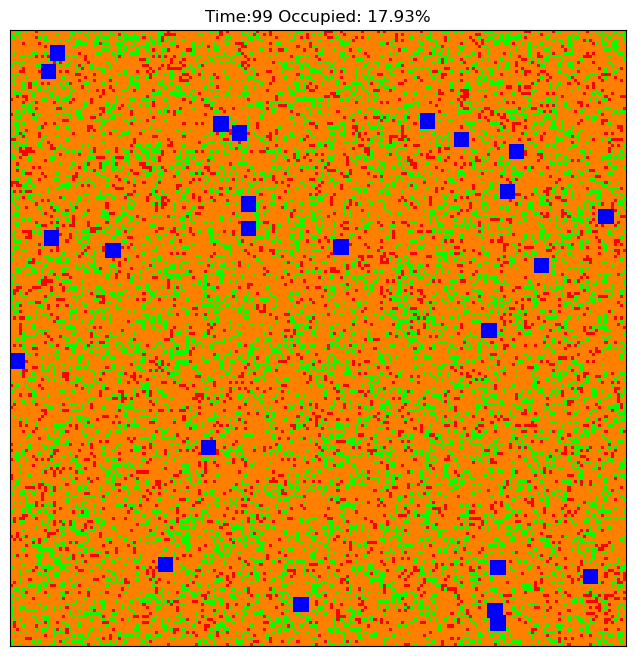

In [5]:

fire = ForestFire(200, p=0.1, f=0.05, w=5)


animation = Animation2D(fire, frames=100)
animation.animate(0.3)


In [6]:
treesFound = len(fire.trees)
xCor, yCor = fire.trees[ np.random.randint( treesFound ) ]
print(xCor, yCor)
print(fire.state[xCor, yCor])

103 191
0


## Steady State

The values, 200, p=0.1, f=0.05 are previously known stable values from Lab 8, in this model, we'll put in some water and lakes

5 Lakes of 5*5 size.
At this size, the forest stability seems to have not changed

500


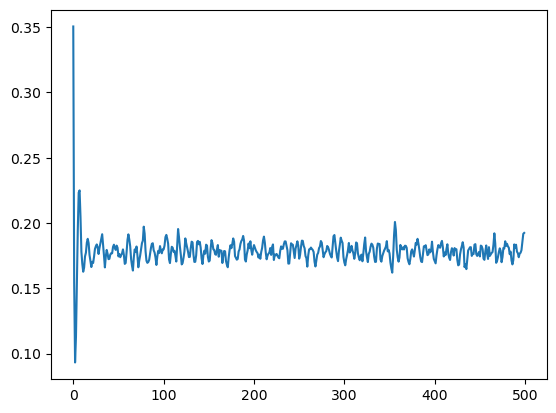

In [7]:
# n: number of rows
# p: probability an empty cells becomes "forested" (occupied)
# f: probability of spontaneous file (e.g., 1/fire ignition interval)
# q: initial forest density (probability cell is "forested" in initial state)
occupied = []
def stab(steady, occup, offset=0, length=500):
    for i in range(length):
        steady.step()
        occup.append(steady.pct_occupied(arg=steady.OCCUPIED))
    print(len(occup))
    fig, ax = plt.subplots(1, 1)
    ax.plot(range(length+offset), occup)


steady = ForestFire(100, p=0.1, f=0.05, w=5, lakes=5)
stab(steady,occupied)

No Lakes but human-made random water splashes of size 50. Effects of a helicopter spraying water.

At this size of water, the entire forest is taken over by water and no more fires/flammable elements exist. The forest is aved.


With random water splashes, the forest occupancy ripples a bit less in the beginning.

500


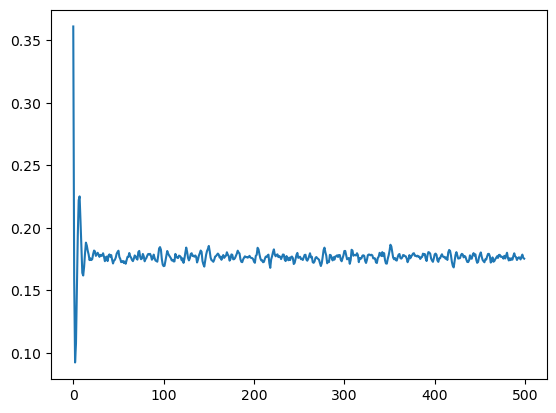

In [8]:
# n: number of rows
# p: probability an empty cells becomes "forested" (occupied)
# f: probability of spontaneous file (e.g., 1/fire ignition interval)
# q: initial forest density (probability cell is "forested" in initial state)
occupied = []
steady = ForestFire(200, p=0.1, f=0.05, w=5, lakes=0)
stab(steady,occupied)

# Model stability with external disturbances

We could have a function insert major fires into the forest after it's been stabilized(we can get this data from above for an accurate answer.) 

It seems that the system is completely stable. 

This is the exact same result as the original experiment. The system is equally immune to external factors. With or without outside human help.

50
466
100
466
150


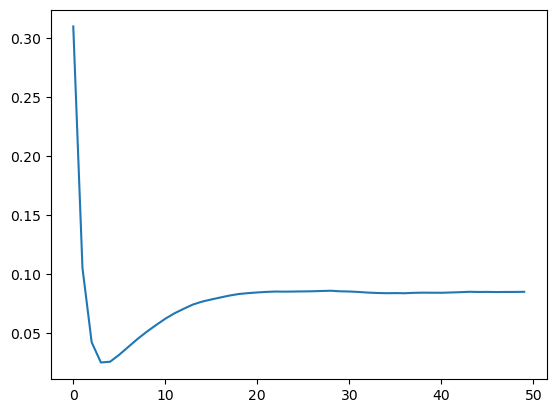

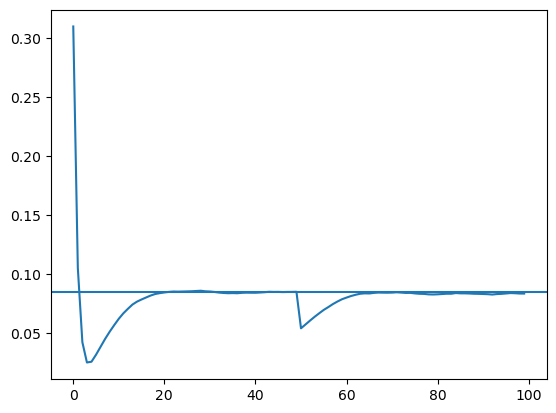

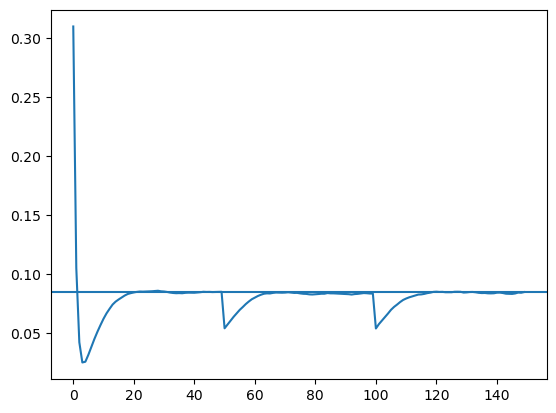

In [11]:
def insertFire(ff):
    third = ff.state.shape[0] // 3
    position = third+300
    print(position)
    ff.state[third:position, third:position] = ff.FIRE
    
hell = ForestFire(500, p=0.01, f=0.05)

occupied = []
stab(hell, occupied, length=50)

insertFire(hell)
stab(hell, occupied, offset=50, length=50)
plt.axhline(y=0.085)

insertFire(hell)
stab(hell, occupied, offset=100, length=50)
plt.axhline(y=0.085)

### Lakes
By adding natural lakes in the initialization , there's no different whatsoever between this and having the forest burn on its own.

50
466
100
466
150


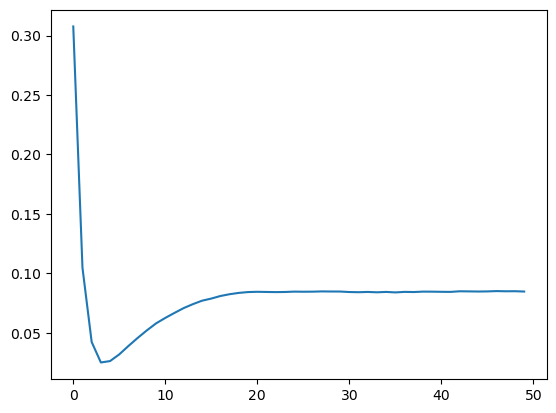

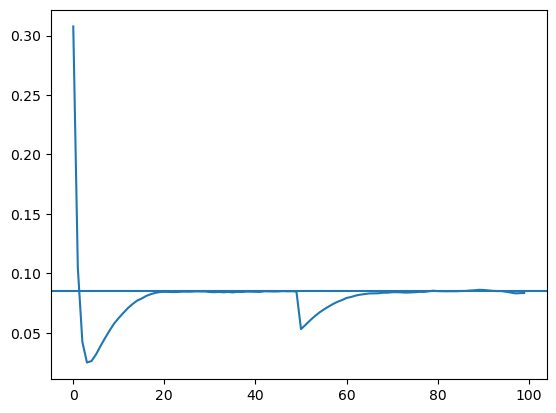

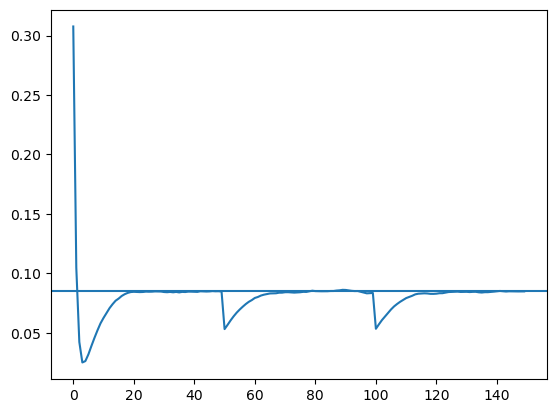

In [12]:
hell = ForestFire(500, p=0.01, f=0.05, lakes=30)

occupied = []
stab(hell, occupied, length=50)

insertFire(hell)
stab(hell, occupied, offset=50, length=50)
plt.axhline(y=0.085)

insertFire(hell)
stab(hell, occupied, offset=100, length=50)
plt.axhline(y=0.085)

### Some interesting finds:

If our forest is too small, let's say a size of 10 or 20, with a water patch size of 1 even, our model fails to produce anything since the forest is way too easy to put by random waters which are basically firefighters

#### The concluding results are the exact same as Lab 8 in this model:
- It returns to the same steady state and it stays at the same value.

- It takes this exact model (p=0.01, f=0.05) about ~18 time steps to reach equilibrium again.

- The larger the disturbance, the more change is seen. but it doesn't change the attractor at all.

- Only the forestation, fire and initial occupancy affect the attractors.

### In what ways might the extended model contribute to our understanding of fire-mediated landscape patterns?
We could take away that with or without human help, a forest of significant size will eventually burn out with very small forestation afterwards.

## Timings/Algorithm analysis
Already, scipy's correlate2d has a time complexity of `O(MNK^2)` because M and N are the dimensions of the array and K is the dimension of the fixed kernel.
Further into the program, looking for water spots also has its own time complexity.
So our final time complexity would be going through the entire array again: `O(MN^2K^2)`

### Algorithm time complexity
In order to finish the simulations above:

In [13]:
generations = 500
size = 500

fire = ForestFire(size, p=0.01, f=0.05)
time = timeit.timeit(fire.step, number=generations)
print(f'Took {time} seconds for {generations} generations in a grid of size {size}x{size}')

Took 6.222250942999381 seconds for 500 generations in a grid of size 500x500


#### Much faster with a smaller size. 1/5 of the size but the decay is exponential

In [14]:
generations = 500
size = 100

fire = ForestFire(size, p=0.01, f=0.05)
time = timeit.timeit(fire.step, number=generations)
print(f'Took {time} seconds for {generations} generations in a grid of size {size}x{size}')

Took 0.3345538980065612 seconds for 500 generations in a grid of size 100x100
